In [39]:
%matplotlib inline
import json, os, re, shutil, sys, time
import collections, itertools
import unittest
from IPython.display import display, HTML
import numpy as np
# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

# Defining Functions

In [40]:
def load_results(save_folder_name):
    '''
    Loads model training results saved in Classification-LSTM.ipynb
    Returns a dataframe of predictions for each epoch and a dictionary mapping author names to IDs
    '''
    RESULTS_SAVE_DIR = './nn_saved_results/' + save_folder_name
    author_to_id = pickle.load(open(RESULTS_SAVE_DIR + '/author_to_id.p', 'rb'))
    df = pd.read_csv(RESULTS_SAVE_DIR + '/results.csv', index_col=0)
    return df, author_to_id

def id_to_author(author_to_id, id):
    '''
    Takes a dictionary mapping author names to IDs and an ID, and returns
    the author mapped to that ID
    '''
    for author, author_id in author_to_id.iteritems():
        if id == author_id:
            return author

def rect_to_polar(rect_point):
    '''
    Converts an (x,y) tuple of a cartesian point to an (radius, angle) tuple in polar form.
    '''
    x, y = rect_point
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    return (r,theta)

def polar_to_rect(polar_point):
    '''
    Converts a (radius, angle) tuple of a polar point to an (x,y) tuple in cartesian form.
    '''
    r, theta = polar_point
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return (x,y)

def polar_to_rect_sum(radii, angles):
    '''
    Accepts a series of radii and a series of angles that together form polar coordinates.
    Converts these points to cartesian coordinates and returns their vector sum in cartesian.
    '''
    polar_points = zip(radii, angles)
    rect_points = [polar_to_rect(point) for point in polar_points]
    return [sum(coord) for coord in zip(*rect_points)]

In [46]:
def plot_polar(epoch_spacing=10, specific_papers_to_plot=[], df=df, author_to_id=author_to_id):
    '''
    Creates a polar plot of the epoch training predictions in df. Each epoch is plotted as a series
    of points, with each point representing the vector sum of predictions for a paper in that epoch.
    The plot has authors arranged at equidistant angles, and predictions for a paper are treated as
    the magnitude of a polar vectors in the direction of the respective authors. This function
    takes those vectors, converts them to cartesian coordinates so that they can be summed, and then
    returns the vector sums to polar coordinates for plotting.
    
    INTERPRETATION: The graph is effectively split into equal pie-shaped regions for each author, delineated
    by the axis lines between them. If a paper is in an author's region, that author received the highest
    probability prediction. Distance from center indicates a stronger leaning. Papers in an epoch have the same
    color, and epoch colors are on a red scale that goes from light to dark for later epochs. The final epoch
    is always in green for easy viewing.
    
    INPUTS: 
      - epoch_spacing determines how frequently an epoch is plotted. The first and last are always plotted.
      Plotting every epoch can get messy, so this allows fewer. Example: If a model with 104 epochs is plotted
      with epoch_spacing=10, the epochs [1, 10, 20, 30, ... , 80, 90, 100, 104] will be plotted.
      - specific_papers_to_plot allows the user to identify the list of papers that will be plotted. An empty list
      or None will plot all papers. Papers should be passed as a list of numbers taken from the set [18-20, 49-58, 62,63,72]
    '''
    author_ids = df.index.unique()
    epoch_ids = df.epoch.unique()
    author_count = len(author_ids)
    epoch_count = len(epoch_ids)

    angle_width_radian = 2 * np.pi / author_count
    author_angles = author_ids * angle_width_radian
    
    # Creating plot with polar axis and evenly spaced coordinates for each author
    plt.figure(figsize=(10,10))
    ax = plt.axes(polar=True)

    tick_angles = []
    tick_labels = []
    for i in range(len(author_angles)-1):
        tick_angles.append(author_angles[i])
        tick_angles.append((author_angles[i] + author_angles[i+1]) / 2.0)
        tick_labels.append(id_to_author(author_to_id, author_ids[i]))
        tick_labels.append('')

    tick_angles.append(author_angles[-1])
    tick_angles.append((author_angles[-1] + 2*np.pi) / 2.0)
    tick_labels.append(id_to_author(author_to_id, author_ids[-1]))
    tick_labels.append('')

    ax.set_xticks(tick_angles)
    #[id_to_author(author_to_id, aid) for aid in author_ids]
    # ax.set_xticklabels(['J.M.', 'A.H.', 'J.J.'], size=12)
    ax.set_xticklabels(tick_labels, size=12)
    ax.set_rlim(0,1)

    # Setting colors for each epoch
    cmap = cm.Reds # selecting color map
    epoch_colors = [cmap(val) for val in np.linspace(0,1, len(epoch_ids))] # list of colors from colormap
    epoch_colors[-1] = 'green'
    # epoch_colors = epoch_colors[::-1] # reversing color list to go from light to dark

    # Selecting evenly-spaced epochs to plot
    epochs_to_plot = list(epoch_ids[::epoch_spacing])
    if epochs_to_plot[0] != 1:
        epochs_to_plot = [1] + epochs_to_plot
    if epochs_to_plot[-1] != epoch_count:
        epochs_to_plot += [epoch_count]

    # indicating which papers to include in the plot
    # set to None or leave as empty list to plot all papers
    if specific_papers_to_plot:
        # converting to strings.
        specific_papers_to_plot = [str(paper_num) for paper_num in specific_papers_to_plot]
    else:
        # including all papers
        specific_papers_to_plot = [str(col_name) for col_name in df.columns[0:-1]]


    ## Looping over each epoch and plotting the vector sums for each paper in that epoch
    for epoch_num in epochs_to_plot:
        # extract scores for the specified papers in this epoch
        temp = df[df.epoch==epoch_num][specific_papers_to_plot]
        # determine angles for the author associated with each row
        angles = [author_angles[int(i)] for i in temp.index]
        # find vector sum of each papers predictions in rectangular coordinates
        rect_points = temp.apply(lambda col: polar_to_rect_sum(col, angles))
        # convert new vectors back to polar for plotting
        polar_points = [rect_to_polar(point) for point in rect_points]
        radii = [point[0] for point in polar_points]
        thetas = [point[1] for point in polar_points]
        plt.plot(thetas, radii, marker='o', linestyle='', color=epoch_colors[epoch_num-1])
    plt.show()

# Loading

In [47]:
save_folder_name = '2017-12-16_06_49_31'
df, author_to_id = load_results(save_folder_name)

In [48]:
author_to_id

{'alexander_hamilton': 1, 'james_madison': 0, 'john_jay': 2}

In [49]:
df

,18,19,20,49,50,51,52,53,54,55,56,57,58,62,63,72,epoch
0.0000,0.6933,0.7133,0.5600,0.5200,0.5200,0.5100,0.5200,0.6267,0.5200,0.4800,0.5100,0.5333,0.6133,0.5467,0.5150,0.5600,1
1.0000,0.1600,0.1000,0.2300,0.1900,0.2000,0.3200,0.2600,0.2400,0.2800,0.2800,0.2700,0.3000,0.2133,0.2867,0.2600,0.3100,1
2.0000,0.1467,0.1867,0.2100,0.2900,0.2800,0.1700,0.2200,0.1333,0.2000,0.2400,0.2200,0.1667,0.1733,0.1667,0.2250,0.1300,1
0.0000,0.6000,0.6733,0.5100,0.4800,0.6000,0.5400,0.5300,0.5933,0.5100,0.5100,0.5300,0.5400,0.5800,0.5133,0.5200,0.5100,2
1.0000,0.2933,0.2000,0.2800,0.2900,0.2400,0.3500,0.3200,0.3067,0.3200,0.3400,0.3000,0.3200,0.3533,0.3400,0.3450,0.3700,2
2.0000,0.1067,0.1267,0.2100,0.2300,0.1600,0.1100,0.1500,0.1000,0.1700,0.1500,0.1700,0.1400,0.0667,0.1467,0.1350,0.1200,2
0.0000,0.6067,0.6400,0.5500,0.4800,0.5200,0.5300,0.5200,0.6133,0.5400,0.5500,0.5100,0.5800,0.6267,0.4867,0.5750,0.5600,3
1.0000,0.2200,0.1533,0.2600,0.3100,0.3000,0.3200,0.3100,0.2600,0.2900,0.2900,0.2800,0.2467,0.2467,0.3400,0.2750,0.2800,3
2.0000,0.1733,0.2067,0.1900,0.2100,0.1800,0.1500,0.1700,0.1267,0.1700,0.1600,0.2100,0.1733,0.1267,0.1733,0.1500,0.1600,3
0.0000,0.5667,0.6467,0.4900,0.4800,0.5400,0.5300,0.5100,0.5133,0.5200,0.4900,0.4300,0.5133,0.5067,0.4933,0.4750,0.4100,4


# Analysis

### Demonstrating polar plotting

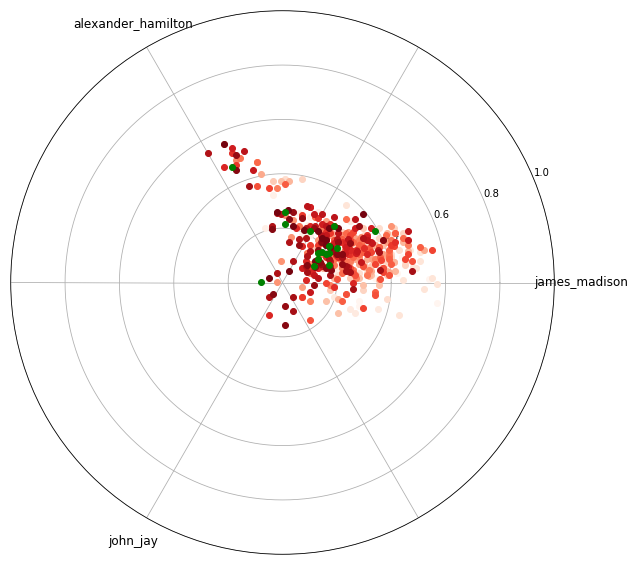

In [50]:
plot_polar(epoch_spacing=10, specific_papers_to_plot=[])